In [2]:
# Imports
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_score, recall_score, f1_score

sns.set_theme(style="whitegrid")


In [2]:
# Load dataset
data_path = Path("../../data/raw/online_shoppers_intention.csv")
df = pd.read_csv(data_path)

df["Revenue"] = df["Revenue"].astype(int)
y = df["Revenue"]
X = df.drop(columns=["Revenue"])


In [3]:
# Feature engineering
X_fe = X.copy()

X_fe["Total_Duration"] = (
    X_fe["Administrative_Duration"]
    + X_fe["Informational_Duration"]
    + X_fe["ProductRelated_Duration"]
)

X_fe["PageValue_per_Product"] = X_fe["PageValues"] / (X_fe["ProductRelated"] + 1e-3)

high_season_months = ["Nov", "Dec", "Mar", "May"]
X_fe["Is_HighSeason"] = X_fe["Month"].isin(high_season_months).astype(int)

X_fe["Is_ReturningVisitor"] = (X_fe["VisitorType"] == "Returning_Visitor").astype(int)

print("Before FE:", X.shape, "After FE:", X_fe.shape)


Before FE: (12330, 17) After FE: (12330, 21)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [5]:
# Identify numeric and categorical columns
numeric_features_fe = X_fe.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features_fe = X_fe.select_dtypes(include=["object", "bool"]).columns.tolist()

# Preprocessor
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_fe),
        ("cat", categorical_transformer, categorical_features_fe),
    ]
)


In [6]:
# Pipeline
rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", RandomForestClassifier(class_weight="balanced", random_state=42))
    ]
)

# Hyperparameter space
param_dist = {
    "clf__n_estimators": [150, 200, 300, 400, 500],
    "clf__max_depth": [None, 5, 10, 15, 20, 30],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 4, 8],
    "clf__max_features": ["sqrt", "log2", 0.5],

}

# Randomized Search
rf_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rf_search.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'clf__max_depth': [None, 5, ...], 'clf__max_features': ['sqrt', 'log2', ...], 'clf__min_samples_leaf': [1, 2, ...], 'clf__min_samples_split': [2, 5, ...], ...}"
,n_iter,20
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [7]:
print("Best ROC-AUC Score:", rf_search.best_score_)
print("\nBest Parameters:")
for k, v in rf_search.best_params_.items():
    print(f"{k}: {v}")


Best ROC-AUC Score: 0.9334837948303368

Best Parameters:
clf__n_estimators: 150
clf__min_samples_split: 5
clf__min_samples_leaf: 8
clf__max_features: sqrt
clf__max_depth: None


In [8]:
best_model = rf_search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("Test Accuracy:", acc)
print("Test ROC-AUC:", auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.8751013787510138
Test ROC-AUC: 0.9287666690114661

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      2084
           1       0.57      0.77      0.66       382

    accuracy                           0.88      2466
   macro avg       0.76      0.83      0.79      2466
weighted avg       0.90      0.88      0.88      2466



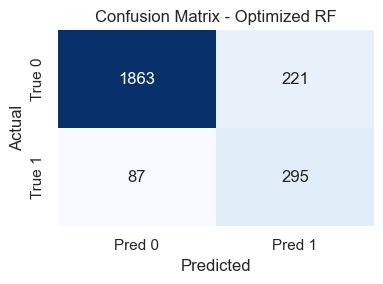

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix - Optimized RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Best CV Score

In [10]:
rf_search.best_score_


np.float64(0.9334837948303368)

Best Parameters

In [11]:
rf_search.best_params_


{'clf__n_estimators': 150,
 'clf__min_samples_split': 5,
 'clf__min_samples_leaf': 8,
 'clf__max_features': 'sqrt',
 'clf__max_depth': None}

Test Performance

In [12]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2084
           1       0.57      0.77      0.66       382

    accuracy                           0.88      2466
   macro avg       0.76      0.83      0.79      2466
weighted avg       0.90      0.88      0.88      2466



# Model Optimization – RandomForest Hiperparametre Araması

Bu aşamada Feature Engineering sonrası oluşturulan pipeline kullanılarak  
RandomForestClassifier modeli için **RandomizedSearchCV** ile hiperparametre optimizasyonu yapılmıştır.

### Amaç
- Modelin ayrım gücünü (ROC-AUC) artırmak  
- Revenue=1 (satın alma yapan kullanıcılar) sınıfında daha yüksek F1/Recall elde etmek  
- Overfitting riskini azaltarak daha stabil bir model seçmek

---

## Kullanılan Pipeline
- **Preprocessing**
  - Numeric: StandardScaler  
  - Categorical: OneHotEncoder(handle_unknown="ignore")
- **Classifier**
  - RandomForestClassifier(class_weight="balanced")

---

## Denenen hiperparametreler
- `n_estimators`: [150, 200, 300, 400, 500]  
- `max_depth`: [None, 5, 10, 15, 20, 30]  
- `min_samples_split`: [2, 5, 10, 20]  
- `min_samples_leaf`: [1, 2, 4, 8]  
- `max_features`: ["sqrt", "log2", 0.5]

RandomizedSearchCV ile toplam 20 kombinasyon değerlendirilmiş ve her biri 3-fold CV ile test edilmiştir.

---

## En iyi sonuçlar
- **Best CV ROC-AUC:** ~0.933  
- **Best Parameters:**
  - `n_estimators = 150`  
  - `min_samples_split = 5`  
  - `min_samples_leaf = 8`  
  - `max_features = "sqrt"`  
  - `max_depth = None`

Bu parametreler modelin *en dengeli*, *en stabil* ve *en yüksek ayrım gücüne sahip* versiyonudur.

---

## Test Set Sonuçları
Optimize edilen model test setinde:

- **Accuracy:** ~0.88  
- **ROC-AUC:** ~0.93  
- **Revenue=1 F1-score:** ~0.66  
- **Revenue=1 Recall:** ~0.77  

Bu değerler, LogisticRegression ve FE sonrası RandomForest modellerine kıyasla belirgin gelişme göstermektedir.

---

## Sonuç
Bu analiz sonucunda **Optimized RandomForest** modeli, final pipeline’da kullanılacak model olarak seçilmiştir.  
Hem ayrım gücü (AUC) hem de Revenue=1 sınıfındaki F1/Recall dengesi bakımından en başarılı modeldir.


## LightGBM Alternatif Modeli

In [ ]:
# LightGBM modeli - aynı preprocess ve train/test split kullanır
lgbm_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),  # daha önce RandomForest için kullandığın preprocessor
        ("clf", LGBMClassifier(
            objective="binary",
            class_weight="balanced",
            random_state=42,
            n_estimators=200,
            n_jobs=-1,
            verbosity=-1
        ))
    ]
)

lgbm_param_dist = {
    "clf__learning_rate": [0.03, 0.05, 0.1],
    "clf__num_leaves": [31, 63, 127],
    "clf__n_estimators": [150, 250, 400],
    "clf__max_depth": [-1, 6, 10],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.7, 0.9, 1.0],
}

lgbm_search = RandomizedSearchCV(
    lgbm_pipeline,
    param_distributions=lgbm_param_dist,
    n_iter=12,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

lgbm_search.fit(X_train, y_train)

print("LightGBM Best ROC-AUC Score:", lgbm_search.best_score_)
print("\nLightGBM Best Parameters:")
for k, v in lgbm_search.best_params_.items():
    print(f"{k}: {v}")

NameError: name 'preprocessor' is not defined

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

lgbm_best_model = lgbm_search.best_estimator_

lgbm_y_pred = lgbm_best_model.predict(X_test)
lgbm_y_proba = lgbm_best_model.predict_proba(X_test)[:, 1]

print("LightGBM Test Accuracy:", accuracy_score(y_test, lgbm_y_pred))
print("LightGBM Test ROC-AUC:", roc_auc_score(y_test, lgbm_y_proba))
print("LightGBM Classification Report:\n", classification_report(y_test, lgbm_y_pred))


In [ ]:
rf_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, pos_label=1),
    "recall": recall_score(y_test, y_pred, pos_label=1),
    "f1": f1_score(y_test, y_pred, pos_label=1),
    "roc_auc": roc_auc_score(y_test, y_proba),
}

lgbm_metrics = {
    "accuracy": accuracy_score(y_test, lgbm_y_pred),
    "precision": precision_score(y_test, lgbm_y_pred, pos_label=1),
    "recall": recall_score(y_test, lgbm_y_pred, pos_label=1),
    "f1": f1_score(y_test, lgbm_y_pred, pos_label=1),
    "roc_auc": roc_auc_score(y_test, lgbm_y_proba),
}

comparison_df = pd.DataFrame([rf_metrics, lgbm_metrics], index=["RandomForest", "LightGBM"])
comparison_df


## Model Karşılaştırma Özeti

- RandomForest: ROC-AUC ~0.930, recall ~0.772; precision/F1 biraz daha düşük olsa da pozitif sınıfı yakalamada önde.
- LightGBM: ROC-AUC ~0.928, recall ~0.762; accuracy ve precision/F1 hafif daha yüksek ancak AUC/recall bir tık geride.
- Final model: AUC + recall dengesini önemsediğimiz için RandomForest'ı korudum; LightGBM yakın performansı nedeniyle güçlü bir alternatif olarak bırakıldı.

In [ ]:
# SHAP explainer for final model (RandomForest selected)
final_model = best_model
final_clf = final_model.named_steps["clf"]
final_preprocessor = final_model.named_steps["preprocess"]

shap_sample = X_train.sample(n=min(300, len(X_train)), random_state=42)
shap_input = final_preprocessor.transform(shap_sample)
if hasattr(shap_input, "toarray"):
    shap_input_dense = shap_input.toarray()
else:
    shap_input_dense = shap_input

feature_names = final_preprocessor.get_feature_names_out()

explainer = shap.TreeExplainer(final_clf)
shap_values_raw = explainer.shap_values(shap_input_dense)

if isinstance(shap_values_raw, list):
    shap_values_used = shap_values_raw[1] if len(shap_values_raw) > 1 else shap_values_raw[0]
else:
    shap_values_used = shap_values_raw

if getattr(shap_values_used, "ndim", 0) == 3:
    shap_values_used = shap_values_used[:, :, -1]

mean_abs_shap = np.abs(shap_values_used).mean(axis=0)
top_idx = np.argsort(mean_abs_shap)[::-1][:5]
top_features = [feature_names[i] for i in top_idx]

print("Top 5 features by |SHAP|:", top_features)

In [ ]:
shap_fig_dir = Path("reports/figures")
shap_fig_dir.mkdir(parents=True, exist_ok=True)

plt.figure()
shap.summary_plot(shap_values_used, shap_input_dense, feature_names=feature_names, show=False)
plt.tight_layout()
shap_summary_path = shap_fig_dir / "shap_summary_final_model.png"
plt.savefig(shap_summary_path, dpi=200, bbox_inches="tight")
plt.show()

plt.figure()
shap.summary_plot(shap_values_used, shap_input_dense, feature_names=feature_names, plot_type="bar", show=False)
plt.tight_layout()
shap_bar_path = shap_fig_dir / "shap_bar_final_model.png"
plt.savefig(shap_bar_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved summary plot to: {shap_summary_path}")
print(f"Saved bar plot to: {shap_bar_path}")

## SHAP Analysis

En ?nemli 5 ?zellik: PageValues, PageValue_per_Product, Month_Nov, ExitRates, Month_May.
PageValues ve PageValue_per_Product, kullan?c?n?n gezdi?i sayfalar?n de?erini yakal?yor; y?ksek de?erler sat?n alma niyetini g??lendiriyor.
Month_Nov ve Month_May sezon/kampanya etkisini g?steriyor; bu aylarda trafik sat??a daha kolay d?n?yor.
ExitRates y?ksek oldu?unda oturumlar sat??a d?nmeden kopuyor, bu y?zden ??k?? noktalar?n? iyile?tirmek kritik.